<a href="https://colab.research.google.com/github/claudiaxpreda/SII/blob/main/SII_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from __future__ import print_function


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
WORKDIR = os.getcwd()
PATH_TRAIN_DATA_K = WORKDIR + '/drive/MyDrive/SII/toxic_comment_dataset/train/train.csv'
PATH_TEST_DATA_K = WORKDIR + '/drive/MyDrive/SII/toxic_comment_dataset/test/test.csv'

PATH_TRAIN_DATA_TRAC = WORKDIR + '/drive/MyDrive/SII/trac1-dataset/english/agr_en_train.csv'
PATH_TEST_DATA_TRAC = WORKDIR + '/drive/MyDrive/SII/trac1-dataset/english/agr_en_dev.csv'


def get_train_data(path):
  return pd.read_csv(path)

def get_test_data(path):
  return pd.read_csv(path)

print('Nope')

Nope


Analyze the Kaggle competition dataset.

As seen below, the dataset is unbalanced, most of the comments are non-toxic and
many Kaggle users suspects that this can be a factor for the good results obtained while training using simple methods.


In [ ]:
''' 
  Visualize the train data
'''

get_train_data(PATH_TRAIN_DATA_K).head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
''' 
  Analyzing the data set
'''

train_data = get_train_data(PATH_TRAIN_DATA_K)
print ('The data contains {} comments'.format(train_data.shape[0]))
print ('Number of collumns: {}'.format(train_data.shape[1]))
print ('Name of the columns in the dataset')
print(train_data.columns.to_list())



The data contains 159571 comments
Number of collumns: 8
Name of the columns in the dataset
['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [ ]:
data_numeric = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
for i in data_numeric:
    print(f"Percentage of 1 and 0 in {i.upper()}")
    print(round(train_data[i].value_counts(1)*100,2))

Percentage of 1 and 0 in TOXIC
0    90.42
1     9.58
Name: toxic, dtype: float64
Percentage of 1 and 0 in SEVERE_TOXIC
0    99.0
1     1.0
Name: severe_toxic, dtype: float64
Percentage of 1 and 0 in OBSCENE
0    94.71
1     5.29
Name: obscene, dtype: float64
Percentage of 1 and 0 in THREAT
0    99.7
1     0.3
Name: threat, dtype: float64
Percentage of 1 and 0 in INSULT
0    95.06
1     4.94
Name: insult, dtype: float64
Percentage of 1 and 0 in IDENTITY_HATE
0    99.12
1     0.88
Name: identity_hate, dtype: float64


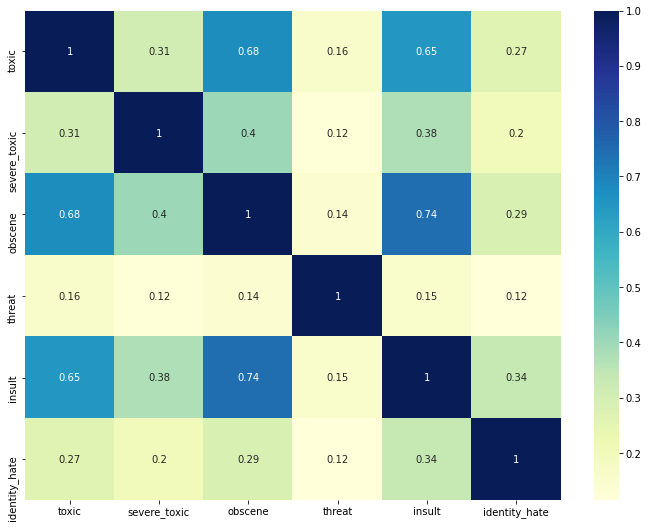

In [ ]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (12,9))
sns.heatmap(train_data.corr(),cmap='YlGnBu',annot=True)
plt.show()

Analyzing the TRAC dataset, which has the following aggretion labels:
NAG = Not-Agrresiv
OAG = Overly-Agressive
CAG = Covertly-Aggresive

It seems more suitable for our task:


In [ ]:
''' 
  Visualize the train data from TRAC
'''

train_data_trac = get_train_data(PATH_TRAIN_DATA_TRAC)
train_data_trac.columns = ['unique_id', 'text', 'agression_level']
train_data_trac.head()

,unique_id,text,agression_level
0,facebook_corpus_msr_466073,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
1,facebook_corpus_msr_1493901,"Now question is, Pakistan will adhere to this?",OAG
2,facebook_corpus_msr_405512,Pakistan is comprised of fake muslims who does...,OAG
3,facebook_corpus_msr_1521685,"??we r against cow slaughter,so of course it w...",NAG
4,facebook_corpus_msr_462570,Wondering why Educated Ambassador is strugglin...,CAG


In [ ]:
print ('The data contains {} comments'.format(train_data_trac.shape[0]))
print ('Number of collumns: {}'.format(train_data_trac.shape[1]))
print ('Name of the columns in the dataset')
print(train_data_trac.columns.to_list())

The data contains 11998 comments
Number of collumns: 3
Name of the columns in the dataset
['unique_id', 'text', 'agression_level']


In [ ]:
print('Value proportion of agression level:')
print(train_data_trac['agression_level'].value_counts(normalize=True) * 100)

Value proportion of agression level:
NAG    42.098683
CAG    35.339223
OAG    22.562094
Name: agression_level, dtype: float64


Next step is to clean the datasets:

In [ ]:
import re
import string                             

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer 


def clean_data(data):
    punct_tag=re.compile(r'[\.,!?;:]+')
    data=punct_tag.sub(r'',data)

    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)

    url_clean= re.compile(r'(?i)(?:(?:http(?:s)?:)|(?:www\.))\S+')
    data=url_clean.sub(r'',data)

    # spaces_clean= re.compile(r'\s\s+')
    # data=spaces_clean.sub(r'',data)

    # newlines_clean = re.compile(r'[\r|\n|\r\n]+')
    # data = newlines_clean.sub(r'', data)

    #TODO: see if punctuations can help
    punctuations_clean = re.compile(r'[\.,!?;:]+')
    data = punctuations_clean.sub(r'', data)

    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)

    #TODO: make use of the emoji symbols?
    #TODO: expand abrevviations?

    return data

def apply_clean_data(data, tag):
  data[tag] = data[tag].apply(lambda z: clean_data(z))

    
def add_clean_field_K(data):
  data['clean'] = np.where((data['toxic']==0) & 
                           (data['severe_toxic']==0) &
                           (data['obscene']==0) &
                           (data['threat']==0) & 
                           (data['insult']==0) & 
                           (data['identity_hate']==0), 1,0)
  
def lemm_data(comment):
  lemm = WordNetLemmatizer()
  lemm_words =" ".join([lemm.lemmatize(word) for word in comment.split()]) 
  return lemm_words

def apply_lemm_data(data, tag):
  data[tag]=data[tag].apply(lambda z: lemm_data(z))



In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
kaggle_data = get_train_data(PATH_TRAIN_DATA_K)
apply_clean_data(kaggle_data,'comment_text')
add_clean_field_K(kaggle_data)
apply_lemm_data(kaggle_data, 'comment_text')
train_data.head(2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

tfidf_vect = TfidfVectorizer(stop_words='english',ngram_range=(1,3))
train_data_X, test_data_X, train_data_Y, test_data_Y= train_test_split(kaggle_data['comment_text'], kaggle_data[labels], test_size=0.2, random_state=23)

train_data_X = tfidf_vect.fit_transform(train_data_X)
# train_data_Y = kaggle_train_data[labels].values

test_data_X = tfidf_vect.transform(test_data_X)
# test_data_Y = kaggle_test_data[labels].values

print('Final Data dimensions after transformations:', train_data_X.shape, train_data_Y.shape, test_data_X.shape, test_data_Y.shape)

Final Data dimensions after transformations: (127656, 5480967) (127656, 6) (31915, 5480967) (31915, 6)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

model = OneVsRestClassifier(LogisticRegression(), n_jobs = -1)
model.fit(train_data_X, train_data_Y)
print('model: Logistic Regression')
print('mean ROC-AUC on train set:', roc_auc_score(train_data_Y, model.predict_proba(train_data_X)))
y_pred_log = model.predict_proba(test_data_X)
print('mean ROC-AUC on validation set:', roc_auc_score(test_data_Y, y_pred_log))

In [ ]:
model = OneVsRestClassifier(MultinomialNB(), n_jobs = -1)
model.fit(train_data_X, train_data_Y)
print('model: Multinomial Naive Bayes')
print('mean ROC-AUC on train set:', roc_auc_score(train_data_Y, model.predict_proba(train_data_X)))
y_pred_log = model.predict_proba(test_data_X)
print('mean ROC-AUC on validation set:', roc_auc_score(test_data_Y, y_pred_log))

Am folosit două modele de bază în clasificare, NB și Logistic Regression. Concluziile sunt următoarele:


1.  Se obține ușor o performanță ridicată
2.  Se poate îmbunătăți, dar se pune întreabarea dacă  soluția găsită ar avea un caracter relativ general sau va fi specifică acestui set de date.
3. Se ia în calcul posibilitatea alterăii setului de date și idebtificarea problemei care conduce la acest rezultat.






In [ ]:
def add_columns_name_trac(data):
  data.columns = ['unique_id', 'text', 'agression_level']


trac_train_data = get_train_data(PATH_TRAIN_DATA_TRAC)
add_columns_name_trac(trac_train_data)
apply_clean_data(trac_train_data,'text')
apply_lemm_data(trac_train_data, 'text')
trac_train_data.head(2)


,unique_id,text,agression_level
0,facebook_corpus_msr_466073,Most of Private Banks ATM's Like HDFC ICICI et...,NAG
1,facebook_corpus_msr_1493901,Now question is Pakistan will adhere to this,OAG


In [ ]:
trac_test_data = get_train_data(PATH_TEST_DATA_TRAC)
add_columns_name_trac(trac_test_data)
apply_clean_data(trac_test_data,'text')
apply_lemm_data(trac_test_data, 'text')
trac_test_data.head(2)

,unique_id,text,agression_level
0,facebook_corpus_msr_334368,@siva How is ur mother How is ur wife How is u...,NAG
1,facebook_corpus_msr_331195,Also see hw ur RSS activist caught in Burkha t...,NAG


In [ ]:
labels_trac = ['NAG', 'OAG', 'CAG']

for label in labels_trac:
  trac_train_data[label] = np.where(trac_train_data['agression_level'] == label, 1, 0)
  trac_test_data[label] = np.where(trac_test_data['agression_level'] == label, 1, 0)

trac_test_data.head(10)

1000


In [ ]:
tfidf_vect = TfidfVectorizer(stop_words='english',ngram_range=(1,3))

train_data_X = tfidf_vect.fit_transform(trac_train_data['text'])
train_data_Y = trac_train_data[labels_trac]

test_data_X = tfidf_vect.transform(trac_test_data['text'])
test_data_Y = trac_test_data[labels_trac]

print('Final Data dimensions after transformations:', train_data_X.shape, train_data_Y.shape, test_data_X.shape, test_data_Y.shape)

Final Data dimensions after transformations: (11998, 251202) (11998, 3) (3000, 251202) (3000, 3)


In [ ]:
model = OneVsRestClassifier(LogisticRegression(), n_jobs = -1)
model.fit(train_data_X, train_data_Y)
print('model: Logistic Regression')
print('mean ROC-AUC on train set:', roc_auc_score(train_data_Y, model.predict_proba(train_data_X)))
y_pred_log = model.predict_proba(test_data_X)
print('mean ROC-AUC on validation set:', roc_auc_score(test_data_Y, y_pred_log))

model: Logistic Regression
mean ROC-AUC on train set: 0.9874671675932106
mean ROC-AUC on validation set: 0.7521452580785294


In [ ]:
model = OneVsRestClassifier(MultinomialNB(), n_jobs = -1)
model.fit(train_data_X, train_data_Y)
print('model: Multinomial Naive Bayes')
print('mean ROC-AUC on train set:', roc_auc_score(train_data_Y, model.predict_proba(train_data_X)))
y_pred_log = model.predict_proba(test_data_X)
print('mean ROC-AUC on validation set:', roc_auc_score(test_data_Y, y_pred_log))

model: Multinomial Naive Bayes
mean ROC-AUC on train set: 0.9920713419683155
mean ROC-AUC on validation set: 0.7162127197341128


Rezultatele sunt putin mai slabe pentru setul de testare, insa suficient de bune.

Urmatorul pas este ca setul pe care am testat acum sa devina setul de validare,
iar performanta sa va masura pe alte două seturi de date puse la dispozitie:


1.   Cel cu comentarii de pe facebook
2.   Ce cu comenatrii de pw twitter



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Input
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
%matplotlib inline

max_length=200
max_features=20000

class lstm_model(object):
    def __init__(self,max_features=20000):
        self.max_features=max_features
        self.model=Sequential()
        self.model.add(Input(shape=max_length,))
        self.model.add(Embedding(self.max_features,128))
        self.model.add(Bidirectional(LSTM(50, return_sequences=True,recurrent_dropout=0)))
        self.model.add(Bidirectional(LSTM(50, return_sequences=True,recurrent_dropout=0)))
        self.model.add(GlobalMaxPool1D())
        self.model.add(Dense(1,activation='tanh'))
        self.model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        
    def fit(self,X,y,batchsize,epochs):

        self.model.fit(X,y, batch_size=batchsize, epochs=epochs, validation_split=0.2)
        
    def predict(self,data):
        return self.model.predict(data)
        
    
    def predict_classes(self,data):
        return self.model.predict_classes(data)

    def summary(self):
        return self.model.summary()
        

In [ ]:
toxic_model=lstm_model()
toxic_model.summary()
toxic_model.fit(train_data_X.toarray(), train_data_Y.toarray() ,batchsize=100,epochs=4)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200, 100)          71600     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200, 100)          60400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,692,101
Trainable params: 2,692,101
Non-trainable params: 0
_________________________________________________________________


NameError: ignored